In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/NLP_HW6_DS'
else:
  basepath = '/content/drive/MyDrive/NLP_HW6_DS'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torchtext.vocab import vocab
import random
import numpy as np
import joblib
from collections import Counter
from functools import partial
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import os
import wandb

In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models'

In [ ]:
data_folder = '/content/drive/MyDrive/NLP_HW6_DS/datasets'
train_file = 'train.csv'
test_file = 'test.csv'

In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
def basic_clean(text: str) -> str:
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    return re.sub(r'[\n\r]',' ', text)

In [ ]:
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(os.path.join(data_folder, train_file))
test_df = pd.read_csv(os.path.join(data_folder, test_file))

train_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)
test_df.fillna(value={'Tweet': 'placeholder'}, inplace=True)

print("Number of rows in data =",train_df.shape[0])
print("Number of columns in data =",train_df.shape[1])

Number of rows in data = 7724
Number of columns in data = 13


In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


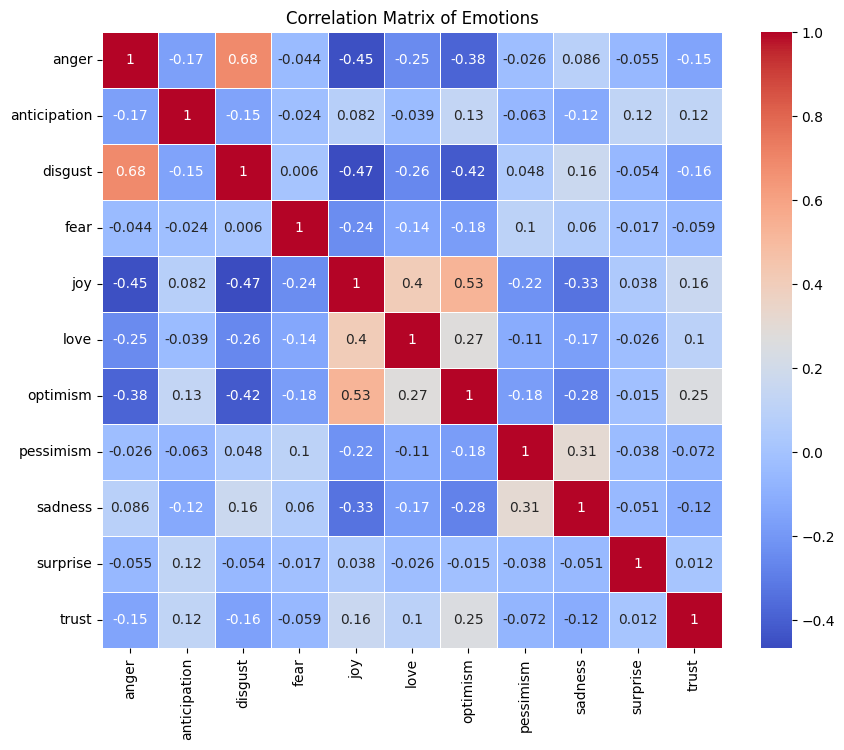

In [ ]:
emotions_corr = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(emotions_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Emotions')
plt.show()


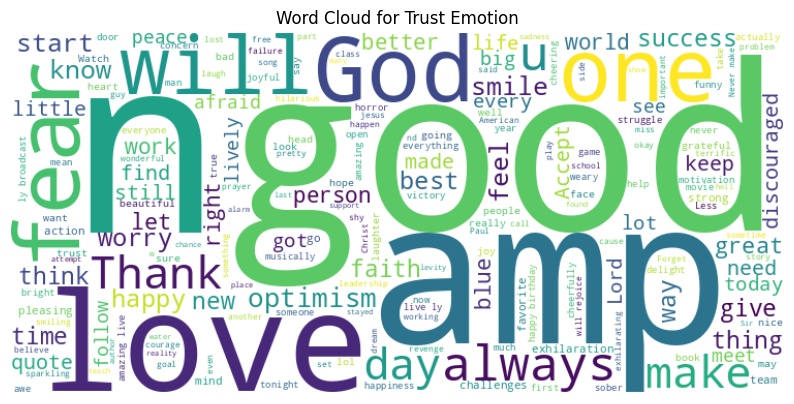

In [ ]:
from wordcloud import WordCloud

text = ' '.join(train_df[train_df['trust'] == 1]['Tweet'])
wordcloud = WordCloud(width=750, height=350, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Trust Emotion')
plt.show()


In [ ]:
train_df,val_df= train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
train_df.shape

(6179, 13)

In [ ]:
val_df.shape

(1545, 13)

In [ ]:
test_df.shape

(3259, 13)

In [ ]:
train_df['Tweet'] = train_df['Tweet'].apply(basic_clean)
val_df['Tweet'] = val_df['Tweet'].apply(basic_clean)
test_df['Tweet'] = test_df['Tweet'].apply(basic_clean)

<ipython-input-6-c6b5f7c192d0>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-6-c6b5f7c192d0>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-6-c6b5f7c192d0>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [ ]:
X_train = train_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_train = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
X_train.shape

(6179, 2)

In [ ]:
y_train.shape

(6179, 11)

In [ ]:
X_val = val_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_val = val_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
test_df.replace('NONE', 0, inplace=True)
X_test = test_df.drop(columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
y_test = test_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].to_numpy()

In [ ]:
trainset = Dataset.from_dict({
    'texts': X_train['Tweet'],
    'labels': y_train
})

validset = Dataset.from_dict({
    'texts': X_val['Tweet'],
    'labels': y_val
})

testset = Dataset.from_dict({
    'texts': X_test['Tweet'],
    'labels': y_test
})

In [ ]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
trainset

Dataset({
    features: ['texts', 'labels'],
    num_rows: 6179
})

In [ ]:
trainset[:1]

{'texts': ["Going to get myself a copy of @StephenKing's CUJO for an upcoming project that I can't talk about just yet.  #amwriting"],
 'labels': [[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]]}

In [ ]:
custom_label_names =['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
test_val_splits = trainset.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


In [ ]:
train_split_small = train_split.shuffle(seed=42).select(range(2000))
val_split_small = val_split.shuffle(seed=42).select(range(500))
test_split_small = test_split.shuffle(seed=42).select(range(500))

In [ ]:
from datasets import DatasetDict
# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split})

# create subsets of train and val datasets
train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

# create subset for test dataset
test_subset = DatasetDict({'test': test_split_small})

In [ ]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [ ]:
train_val_subset['train'].features


{'texts': Value(dtype='string', id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [ ]:
from transformers import AutoTokenizer
checkpoint = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    return tokenizer(batch["texts"], truncation=True)

In [ ]:
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['texts', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['texts', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['texts']
)

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset.set_format(type='torch')
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_label", "labels"))

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 500
    })
})

In [ ]:
tokenized_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}

In [ ]:
tokenized_dataset['train']['labels'][0:3]

tensor([[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.]])

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

25
42


In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels=11
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels,
                                                           problem_type="multi_label_classification")

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.config

T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10"
  },
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  

In [ ]:
custom_label_names

['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
id2label = {}
for id_, label_ in enumerate(custom_label_names):
    id2label[str(id_)] = label_
id2label


{'0': 'anger',
 '1': 'anticipation',
 '2': 'disgust',
 '3': 'fear',
 '4': 'joy',
 '5': 'love',
 '6': 'optimism',
 '7': 'pessimism',
 '8': 'sadness',
 '9': 'surprise',
 '10': 'trust'}

In [ ]:
label2id = {}
for id_, label_ in enumerate(custom_label_names):
    label2id[label_] = id_
label2id


{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'joy': 4,
 'love': 5,
 'optimism': 6,
 'pessimism': 7,
 'sadness': 8,
 'surprise': 9,
 'trust': 10}

In [ ]:
model.config.id2label = id2label
model.config.label2id = label2id

In [ ]:
model.config


T5Config {
  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "10": "trust",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise"
  },
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers"

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
features = [tokenized_dataset["train"][i] for i in range(2)]

In [ ]:
features

[{'input_ids': tensor([  27,  310,  241,   12,  281,   21,    3,   89, 3535,  706,   68,   27,
           310,  278,   31,   17,    3,    2,    1]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.])},
 {'input_ids': tensor([11560,    15,   975,  9454,     7,    12,    82,   803,    44,  3320,
            553,    32,    23,    26,   329,  9881,    15,    30,     8,  1713,
          17663,   345, 26051, 18988,   427,  5721,    55,  1713,  9988,  1713,
            532, 12186,  1713, 30844,  9988,  1713,     7,    75,  1208,     7,
          10536,     1]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'labels': tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])}]

In [ ]:
model_input = data_collator(features)
model_input.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [ ]:
print(model_input.input_ids[0][0:10])
print(model_input.input_ids[0][-20:])
print(model_input.input_ids[1][0:10])
print(model_input.input_ids[1][-20:])

tensor([  27,  310,  241,   12,  281,   21,    3,   89, 3535,  706])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([11560,    15,   975,  9454,     7,    12,    82,   803,    44,  3320])
tensor([26051, 18988,   427,  5721,    55,  1713,  9988,  1713,   532, 12186,
         1713, 30844,  9988,  1713,     7,    75,  1208,     7, 10536,     1])


In [ ]:
print(model_input.attention_mask[0][-20:])
print(model_input.attention_mask[1][-20:])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][0:10]))

['▁I', '▁really', '▁want', '▁to', '▁go', '▁for', '▁', 'f', 'right', '▁night']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[0][-10:]))

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][0:10]))

['▁Hug', 'e', '▁con', 'grat', 's', '▁to', '▁my', '▁friends', '▁at', '▁@']


In [ ]:
print(tokenizer.convert_ids_to_tokens(model_input.input_ids[1][-10:]))

['▁#', 'feature', 'film', '▁#', 's', 'c', 'ary', 's', 'hit', '</s>']


In [ ]:
model=model
model_input= model_input
model.train()
model_output = model(**model_input)

In [ ]:
model_output.keys()

odict_keys(['loss', 'logits', 'encoder_last_hidden_state'])

In [ ]:
model_output.loss

tensor(0.7667, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
model_output.logits

tensor([[ 0.7970, -0.5536,  0.1881,  0.1391, -0.3047, -0.2237, -0.1398,  0.4218,
          0.2971, -0.6949,  0.6039],
        [ 0.0696, -0.3919,  0.1878, -0.0717, -0.0431, -0.2200, -0.0163,  0.4242,
          0.5085, -0.5783,  0.4234]], grad_fn=<AddmmBackward0>)

In [ ]:
model_output.logits.shape

torch.Size([2, 11])

In [ ]:
import torch
from sklearn.metrics import f1_score
import numpy as np

def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    labels = labels.astype(int)  # Convert labels to integer type

    # Check if logits is a tuple (common with some transformer models)
    if isinstance(logits, tuple):
        logits = logits[0]  # Take the first element of the tuple

    labels = torch.tensor(labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    labels = labels.to(device)

    logits = torch.tensor(logits)
    logits = logits.to(labels.device)
    # Convert logits to binary predictions.
    predictions = (logits > 0).cpu().numpy().astype(int)  # Convert to numpy array

    # Flatten the predictions and labels for metric computation.
    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()

    # Compute macro F1 score
    macro_f1 = f1_score(flat_labels.cpu().numpy(), flat_predictions, average='macro')

    # Compute micro F1 score
    micro_f1 = f1_score(flat_labels.cpu().numpy(), flat_predictions, average='micro')

    # Compute label-wise accuracies
    correct_predictions = (predictions == labels.cpu().numpy()).sum(axis=0)
    total_predictions = predictions.shape[0]
    label_accuracies = correct_predictions / total_predictions

    # Compute the average label accuracy
    avg_label_accuracy = np.mean(label_accuracies)

    # Compute accuracy where all labels for an observation need to be correct
    correct_observations = np.all(predictions == labels.cpu().numpy(), axis=1).sum()
    all_accuracy = correct_observations / total_predictions

    # Combine results
    evaluations = {
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'accuracy_all': all_accuracy,
        'avg_label_accuracy': avg_label_accuracy
    }

    return evaluations

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT = HW6DSC

env: WANDB_PROJECT=HW6DSC


In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_hw6_ds/multilabel/google"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="macro_f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'mlabel_exp3',  # Experiment name for Weights & Biases
)


In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.data_collator

DataCollatorWithPadding(tokenizer=T5TokenizerFast(name_or_path='google/flan-t5-base', vocab_size=32100, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>'

In [ ]:
trainer.train()

wandb: Currently logged in as: dipasha-ds (ds1213). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy All,Avg Label Accuracy
20,0.678400,0.646426,0.485020,0.559455,0.002000,0.559455
40,0.627400,0.591267,0.536191,0.756545,0.038000,0.756545
60,0.577200,0.542039,0.490612,0.779091,0.042000,0.779091
80,0.537100,0.503196,0.451938,0.787091,0.036000,0.787091
100,0.501000,0.483448,0.445028,0.788364,0.036000,0.788364
120,0.497700,0.474574,0.440886,0.788545,0.038000,0.788545
140,0.472200,0.470644,0.440886,0.788545,0.038000,0.788545
160,0.472700,0.469465,0.440886,0.788545,0.038000,0.788545
180,0.480700,0.468013,0.441790,0.788727,0.038000,0.788727
200,0.485900,0.466839,0.441790,0.788727,0.038000,0.788727


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


TrainOutput(global_step=250, training_loss=0.5207613983154297, metrics={'train_runtime': 423.3357, 'train_samples_per_second': 9.449, 'train_steps_per_second': 0.591, 'total_flos': 253214018519616.0, 'train_loss': 0.5207613983154297, 'epoch': 2.0})

In [ ]:
trainer.evaluate(tokenized_dataset["val"])


{'eval_loss': 0.5912673473358154,
 'eval_macro_f1': 0.5361914570427764,
 'eval_micro_f1': 0.7565454545454545,
 'eval_accuracy_all': 0.038,
 'eval_avg_label_accuracy': 0.7565454545454545,
 'eval_runtime': 3.9034,
 'eval_samples_per_second': 128.095,
 'eval_steps_per_second': 8.198,
 'epoch': 2.0}

In [ ]:
valid_output = trainer.predict(tokenized_dataset["val"])


In [ ]:
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [ ]:
valid_output.predictions[0:2]

(array([[ 0.07000129, -0.7149632 , -0.06402026, ..., -0.02255841,
         -1.0939643 , -0.2158316 ],
        [ 0.02165926, -0.72410655, -0.06317072, ...,  0.00973182,
         -1.1717979 , -0.22379896],
        [ 0.19325228, -0.88415724, -0.04215789, ..., -0.17869215,
         -1.3083752 , -0.09533603],
        ...,
        [ 0.05555297, -0.81890094, -0.20895733, ..., -0.21820179,
         -1.2221408 , -0.3384683 ],
        [ 0.28268108, -1.0456135 , -0.04715672, ..., -0.17104268,
         -1.5760486 , -0.23399778],
        [ 0.0742835 , -0.910904  , -0.13568632, ..., -0.09785374,
         -1.1635469 , -0.351194  ]], dtype=float32),
 array([[[ 6.37962669e-02,  1.60382211e-01, -5.50685860e-02, ...,
           1.67150065e-01, -5.18166684e-02, -3.73992696e-02],
         [ 3.35304476e-02,  9.92449597e-02, -9.20832232e-02, ...,
           4.48414944e-02,  2.08501324e-01,  1.86450928e-01],
         [ 1.26688667e-02,  1.76930442e-01,  7.01019466e-02, ...,
           8.19255486e-02, -6.752863

In [ ]:
predictions = (valid_output.predictions[0] > 0).astype(int)
labels = valid_output.label_ids.astype(int)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(labels, predictions)
print(mcm)


[[[ 68 263]
  [ 40 129]]

 [[425   0]
  [ 75   0]]

 [[278  46]
  [138  38]]

 [[401   7]
  [ 91   1]]

 [[314   0]
  [186   0]]

 [[447   0]
  [ 53   0]]

 [[343   0]
  [157   0]]

 [[427  14]
  [ 57   2]]

 [[320  31]
  [134  15]]

 [[479   0]
  [ 21   0]]

 [[474   0]
  [ 26   0]]]


In [ ]:
custom_label_names =['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
wandb.finish()


eval/accuracy_all,▁▇█▇▇▇▇▇▇▇▇▇▇
eval/avg_label_accuracy,▁▇██████████▇
eval/loss,█▆▄▂▂▁▁▁▁▁▁▁▆
eval/macro_f1,▄█▅▂▁▁▁▁▁▁▁▁█
eval/micro_f1,▁▇██████████▇
eval/runtime,▁▄▂█▂▂▃▃▃▅▃▃▃
eval/samples_per_second,█▅▇▁▇▇▆▆▆▄▆▆▆
eval/steps_per_second,█▅▇▁▇▇▆▆▆▄▆▆▆
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/grad_norm,▆▇▇▅▅▆█▄█▁▅▂


In [ ]:

best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 40.


In [ ]:
test_subset

DatasetDict({
    test: Dataset({
        features: ['texts', 'labels'],
        num_rows: 500
    })
})

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def evaluator(model, dataset, tokenizer, compute_metrics, batch_size=16):
    """
    Evaluates a model's performance on a given dataset.

    Parameters:
    - model: The trained model to evaluate.
    - dataset: The dataset on which the model will be evaluated.
    - tokenizer: The tokenizer used to preprocess the text data.
    - compute_metrics: A function to compute evaluation metrics.
    - batch_size: Size of batches for evaluation. Default is 16.

    Returns:
    - evaluations: A dictionary containing computed evaluation metrics.
    """

    # Tokenize the dataset and truncate if the tokenized sequence is longer than the model's maximum input length.
    tokenized_dataset = dataset.map(lambda batch: tokenizer(batch["texts"], truncation=True), batched=True)

    # Set the format of the tokenized dataset to be compatible with PyTorch.
    tokenized_dataset.set_format(type='torch')

    # Remove the 'text' column from the tokenized dataset as it's no longer needed post-tokenization.
    tokenized_dataset = tokenized_dataset.remove_columns(['texts'])

    # Define a collation function that pads tokenized sequences to the same length for batching.
    collate_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    # Initialize a DataLoader to iterate over the tokenized dataset in batches.
    dataloader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=collate_fn)

    model.eval()

    # Initialize variables to store the model's logits (raw prediction scores) and true labels.
    eval_logits = []
    eval_labels = []

    # Disable gradient calculations for efficient memory usage during evaluation.
    with torch.inference_mode():
        # Iterate over batches from the DataLoader.
        for batch in dataloader:
            # Prepare the inputs and move them to the GPU.
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

            # Get the model's predictions for the current batch.
            outputs = model(**inputs)
            logits = outputs.logits
            labels = batch['labels']

            # Append the logits and labels of the current batch to the accumulating lists.
            eval_logits.append(logits.cpu().numpy())
            eval_labels.append(labels.cpu().numpy())

    # Concatenate the logits and labels from all batches into numpy arrays.
    eval_logits = np.concatenate(eval_logits, axis=0)
    eval_labels = np.concatenate(eval_labels, axis=0)

    # Compute evaluation metrics using the provided compute_metrics function.
    evaluations = compute_metrics((eval_logits, eval_labels))

    return evaluations

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming 'test_data' is a Dataset with 'texts' and 'labels' columns
texts = test_subset['test']['texts']
labels = test_subset['test']['labels']

# Tokenize the texts using the tokenizer
inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

# Extract input IDs and attention masks from the tokenized inputs
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Convert labels list to a tensor
labels = torch.tensor(labels)

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move tensors to the appropriate device
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)
labels = labels.to(device)

# Ensure model is on the same device as the tensors
model.to(device)

# Perform evaluation
evaluations = evaluator(model, test_subset['test'], tokenizer, compute_metrics, batch_size=16)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
evaluations

{'macro_f1': 0.5462332810434757,
 'micro_f1': 0.7627272727272728,
 'accuracy_all': 0.014,
 'avg_label_accuracy': 0.7627272727272728}

In [ ]:
from transformers import pipeline
checkpoint = str(model_folder/'checkpoint-240')

custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device="cpu",
    return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
sample = test_subset['test']['texts'][0]
sample

'@littlepieces Customer services got involved and eventually completely wash their hands of it. #awful #dreamornightmare'

In [ ]:
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.3793223798274994},
  {'label': 'anticipation', 'score': 0.0976208969950676},
  {'label': 'disgust', 'score': 0.4672709107398987},
  {'label': 'fear', 'score': 0.1405121237039566},
  {'label': 'joy', 'score': 0.32424265146255493},
  {'label': 'love', 'score': 0.08395276218652725},
  {'label': 'optimism', 'score': 0.24426370859146118},
  {'label': 'pessimism', 'score': 0.11419279128313065},
  {'label': 'sadness', 'score': 0.28192025423049927},
  {'label': 'surprise', 'score': 0.03477533534169197},
  {'label': 'trust', 'score': 0.02663666568696499}]]

In [ ]:
sample = test_split['texts'][19]
sample

'Accept the challenges, So that you may feel the exhilaration of victory.\\n\\nTOMIHO IpaglabanMo TapingDay2'

In [ ]:
preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.31218674778938293},
  {'label': 'anticipation', 'score': 0.12161923944950104},
  {'label': 'disgust', 'score': 0.37786364555358887},
  {'label': 'fear', 'score': 0.16266721487045288},
  {'label': 'joy', 'score': 0.3654201030731201},
  {'label': 'love', 'score': 0.1031985878944397},
  {'label': 'optimism', 'score': 0.23729205131530762},
  {'label': 'pessimism', 'score': 0.11960088461637497},
  {'label': 'sadness', 'score': 0.24289263784885406},
  {'label': 'surprise', 'score': 0.06740481406450272},
  {'label': 'trust', 'score': 0.053616032004356384}]]

In [ ]:
predictions = custom_pipeline(test_subset['test']['texts'], truncation=True)

In [ ]:
predictions[:10]

[[{'label': 'anger', 'score': 0.3793223798274994},
  {'label': 'anticipation', 'score': 0.0976208969950676},
  {'label': 'disgust', 'score': 0.4672709107398987},
  {'label': 'fear', 'score': 0.1405121237039566},
  {'label': 'joy', 'score': 0.32424265146255493},
  {'label': 'love', 'score': 0.08395276218652725},
  {'label': 'optimism', 'score': 0.24426370859146118},
  {'label': 'pessimism', 'score': 0.11419279128313065},
  {'label': 'sadness', 'score': 0.28192025423049927},
  {'label': 'surprise', 'score': 0.03477533534169197},
  {'label': 'trust', 'score': 0.02663666568696499}],
 [{'label': 'anger', 'score': 0.36374491453170776},
  {'label': 'anticipation', 'score': 0.11137703061103821},
  {'label': 'disgust', 'score': 0.33388879895210266},
  {'label': 'fear', 'score': 0.13679629564285278},
  {'label': 'joy', 'score': 0.3893817961215973},
  {'label': 'love', 'score': 0.0773884654045105},
  {'label': 'optimism', 'score': 0.2598443031311035},
  {'label': 'pessimism', 'score': 0.087513357

In [ ]:
import numpy as np
from transformers import Pipeline

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

class MultiLabelClassificationPipeline(Pipeline):
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        return preprocess_kwargs, {}, {}

    def preprocess(self, text):
        tokenized = self.tokenizer(text, return_tensors=self.framework, truncation=True, padding=True, max_length=512)
        return tokenized


    def _forward(self, model_inputs):
        model_inputs = {k: v for k, v in model_inputs.items()}
        return self.model(**model_inputs)


    def postprocess(self, model_outputs):
        logits = model_outputs.logits[0].cpu().numpy()
        probabilities = sigmoid(logits)

        threshold = 0
        labels = [self.model.config.id2label[i] for i, prob in enumerate(probabilities) if prob > threshold]

        scores = [prob for prob in probabilities if prob > threshold]
        return {"labels": labels, "scores": scores}


In [ ]:
checkpoint = str(model_folder/'checkpoint-240')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

multi_label_pipeline = MultiLabelClassificationPipeline(model=model, tokenizer=tokenizer)


model.device

device(type='cpu')

In [ ]:
sample = test_subset['test']['texts'][150]
sample

'Today is the first time any math professor let us live early before the class time !!! #15 min #feelsgood #happy #wednesday #'

In [ ]:
preds = multi_label_pipeline(sample)
preds

{'labels': ['anger',
  'anticipation',
  'disgust',
  'fear',
  'joy',
  'love',
  'optimism',
  'pessimism',
  'sadness',
  'surprise',
  'trust'],
 'scores': [0.35353106,
  0.1123218,
  0.2795597,
  0.13650893,
  0.36088344,
  0.08885538,
  0.2936424,
  0.1021848,
  0.21179122,
  0.038515545,
  0.035394654]}

In [ ]:
sample = test_split['texts'][19]
sample

'Accept the challenges, So that you may feel the exhilaration of victory.\\n\\nTOMIHO IpaglabanMo TapingDay2'

In [ ]:
preds = multi_label_pipeline(sample)
preds

{'labels': ['anger',
  'anticipation',
  'disgust',
  'fear',
  'joy',
  'love',
  'optimism',
  'pessimism',
  'sadness',
  'surprise',
  'trust'],
 'scores': [0.31218675,
  0.12161924,
  0.37786365,
  0.16266721,
  0.3654201,
  0.10319859,
  0.23729205,
  0.119600885,
  0.24289264,
  0.067404814,
  0.053616032]}

In [ ]:
predictions = multi_label_pipeline(test_subset['test']['texts'], truncation=True)

In [ ]:
predictions[:10]

[{'labels': ['anger',
   'anticipation',
   'disgust',
   'fear',
   'joy',
   'love',
   'optimism',
   'pessimism',
   'sadness',
   'surprise',
   'trust'],
  'scores': [0.37932238,
   0.0976209,
   0.4672709,
   0.14051212,
   0.32424265,
   0.08395276,
   0.24426371,
   0.11419279,
   0.28192025,
   0.034775335,
   0.026636666]},
 {'labels': ['anger',
   'anticipation',
   'disgust',
   'fear',
   'joy',
   'love',
   'optimism',
   'pessimism',
   'sadness',
   'surprise',
   'trust'],
  'scores': [0.3637449,
   0.11137703,
   0.3338888,
   0.1367963,
   0.3893818,
   0.077388465,
   0.2598443,
   0.08751336,
   0.2218622,
   0.03968967,
   0.031816825]},
 {'labels': ['anger',
   'anticipation',
   'disgust',
   'fear',
   'joy',
   'love',
   'optimism',
   'pessimism',
   'sadness',
   'surprise',
   'trust'],
  'scores': [0.3375084,
   0.11492739,
   0.36528277,
   0.1399921,
   0.37790585,
   0.079554096,
   0.27303192,
   0.09046125,
   0.24042712,
   0.041107476,
   0.02354